# Classical Statistics Approach

Let's start with loading our data, splitting it, then training a model on all possible input variables.

In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import aic
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, recall_score
import pandas as pd
import numpy as np
import math

In [3]:
df1 = pd.read_csv("bankruptcy.csv")
df1['Intercept'] = 1  # allows the regression to have an intercept
x_train, x_test = train_test_split(df1[['X1', 'X2', 'X3', 'X4', 'Intercept']], 
                                   test_size=0.2, random_state=120)
y_train, y_test = train_test_split(df1['Group'], test_size=0.2, random_state=120)

In [4]:
full_model = sm.Logit(y_train, x_train)
full_model_fit = full_model.fit()
print(full_model_fit.summary())

Optimization terminated successfully.
         Current function value: 0.317232
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Group   No. Observations:                   36
Model:                          Logit   Df Residuals:                       31
Method:                           MLE   Df Model:                            4
Date:                Wed, 27 Mar 2024   Pseudo R-squ.:                  0.5382
Time:                        18:09:47   Log-Likelihood:                -11.420
converged:                       True   LL-Null:                       -24.731
Covariance Type:            nonrobust   LLR p-value:                 2.372e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1             6.2847      5.729      1.097      0.273      -4.945      17.514
X2            -3.6808     12.

Now we can see about narrowing the model down. Since the $X_2$ and $X_4$  $p$-values are so high, let's see how the model would fair without them, and compare the Akaike information criterion (AIC) values for the reduced and full models. First, let's just take out $X_1$ for our reduced model, and see how it compares.

In [5]:
# fitting model without X_2
x_train2 = x_train[['X1', 'X3', 'X4', 'Intercept']]
reduced_model1 = sm.Logit(y_train, x_train2)
reduced_model1_fit = reduced_model1.fit()

full_model_aic = aic(llf=full_model.loglike(full_model_fit.params), 
                     nobs=x_train.size, 
                     df_modelwc=len(full_model_fit.params))
print("\n   Full model AIC: {:.3f}".format(full_model_aic))

reduced_model1_aic = aic(llf=reduced_model1.loglike(reduced_model1_fit.params), 
                        nobs=x_train2.shape[0], 
                        df_modelwc=len(reduced_model1_fit.params))
print("Reduced model AIC: {:.3f}".format(reduced_model1_aic))

Optimization terminated successfully.
         Current function value: 0.318429
         Iterations 8

   Full model AIC: 32.841
Reduced model AIC: 30.927


The AIC of a model measures how much information from the original data is <i>lost</i> by the model, so a lower AIC is better. This means the reduced model is better in comparison to the full model. To see if removing another variable improves it further, let's look at the summary of the reduced model:

In [6]:
print(reduced_model1_fit.summary())

                           Logit Regression Results                           
Dep. Variable:                  Group   No. Observations:                   36
Model:                          Logit   Df Residuals:                       32
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 Mar 2024   Pseudo R-squ.:                  0.5365
Time:                        18:09:47   Log-Likelihood:                -11.463
converged:                       True   LL-Null:                       -24.731
Covariance Type:            nonrobust   LLR p-value:                 7.371e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1             4.8697      2.909      1.674      0.094      -0.831      10.570
X3             2.8358      1.051      2.699      0.007       0.776       4.895
X4            -2.2554      3.764     -0.599      0.5

$X_4$ seems to be our next candidate to elimate. So let's try it and see how it goes:

In [7]:
# fitting model without X_2 and X_4
x_train3 = x_train[['X1', 'X3', 'Intercept']]
reduced_model2 = sm.Logit(y_train, x_train3)
reduced_model2_fit = reduced_model2.fit()

print("\n1st reduced model AIC: {:.3f}".format(reduced_model1_aic))

reduced_model2_aic = aic(llf=reduced_model2.loglike(reduced_model2_fit.params), 
                        nobs=x_train3.shape[0], 
                        df_modelwc=len(reduced_model2_fit.params))
print("2nd reduced model AIC: {:.3f}".format(reduced_model2_aic))

Optimization terminated successfully.
         Current function value: 0.323565
         Iterations 8

1st reduced model AIC: 30.927
2nd reduced model AIC: 29.297


Even better! Let's see if we have any insignificant variables still:

In [8]:
print(reduced_model2_fit.summary())

                           Logit Regression Results                           
Dep. Variable:                  Group   No. Observations:                   36
Model:                          Logit   Df Residuals:                       33
Method:                           MLE   Df Model:                            2
Date:                Wed, 27 Mar 2024   Pseudo R-squ.:                  0.5290
Time:                        18:09:47   Log-Likelihood:                -11.648
converged:                       True   LL-Null:                       -24.731
Covariance Type:            nonrobust   LLR p-value:                 2.082e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1             5.5291      2.841      1.946      0.052      -0.039      11.097
X3             2.7476      1.025      2.681      0.007       0.739       4.756
Intercept     -5.1018      1.945     -2.623      0.0

The $X_1$ confidence interval still contains zero, so that means it might not be significant. Let's see how the AIC is when we remove it:

In [9]:
x_train4 = x_train[['X3', 'Intercept']]
reduced_model3 = sm.Logit(y_train, x_train4)
reduced_model3_fit = reduced_model3.fit()

print("\n2st reduced model AIC: {:.3f}".format(reduced_model2_aic))

reduced_model3_aic = aic(llf=reduced_model3.loglike(reduced_model3_fit.params), 
                        nobs=x_train4.shape[0], 
                        df_modelwc=len(reduced_model3_fit.params))
print("3nd reduced model AIC: {:.3f}".format(reduced_model3_aic))

Optimization terminated successfully.
         Current function value: 0.393315
         Iterations 7

2st reduced model AIC: 29.297
3nd reduced model AIC: 32.319


So removing it increases the AIC, meaning that the model is better off with $X_1$ after all. This gives us our final model:

In [10]:
logit_model = reduced_model2
logit_model_fit = reduced_model2_fit
print(logit_model_fit.summary())

                           Logit Regression Results                           
Dep. Variable:                  Group   No. Observations:                   36
Model:                          Logit   Df Residuals:                       33
Method:                           MLE   Df Model:                            2
Date:                Wed, 27 Mar 2024   Pseudo R-squ.:                  0.5290
Time:                        18:09:47   Log-Likelihood:                -11.648
converged:                       True   LL-Null:                       -24.731
Covariance Type:            nonrobust   LLR p-value:                 2.082e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1             5.5291      2.841      1.946      0.052      -0.039      11.097
X3             2.7476      1.025      2.681      0.007       0.739       4.756
Intercept     -5.1018      1.945     -2.623      0.0

## Coefficient estimation
Since the coefficients are already given in the fitted model, we simply need to exponentiate them to get $\exp(\beta_i)$ for $i \in [0,2]$, giving the following:

In [11]:
print("beta", "{:>18}".format("exp(beta_i)"),end=None)
print(logit_model_fit.params.apply(math.exp))

beta        exp(beta_i)
X1           251.905737
X3            15.605700
Intercept      0.006086
dtype: float64


The 95% confidence intervals for these exponentiated coefficients are easily derived as well:

In [12]:
ci_df = logit_model_fit.conf_int(0.95)
ci_df[0] = ci_df[0].apply(math.exp)
ci_df[1] = ci_df[1].apply(math.exp)
print(ci_df)

                    0           1
X1         210.803092  301.022627
X3          14.634346   16.641527
Intercept    0.005387    0.006875


These are multiplicative confidence intervals, which means that they are the <i>product</i> of the estimate and $\exp(\text{MoE})$ (margin of error) or the estimate and $\exp(-\text{MoE})$ for the low end of the interval. Since they are each a 95% confidence interval, that means that, of all possible values of the given parameter, 95% of those values will fall into the interval.

## Error analysis
First, we'll compute the error rate, which is simply complement of accuracy:

In [13]:
x_test = x_test[['X1', 'X3', 'Intercept']]
y_pred = logit_model_fit.predict(x_test)
y_pred = y_pred.apply(round)     # take continuous probabilities and round them to 1 or 0

pred_perf_dict = {
    "True_Y": y_test,
    "Predictions": y_pred}
pred_perf = pd.DataFrame(pred_perf_dict)
pred_perf.reset_index(drop=True, inplace=True)
pred_perf['Correct'] = (pred_perf['True_Y'] == pred_perf['Predictions'])

# divide True's (1's) by size to get accuracy
error_rate = 1 - pred_perf['Correct'].sum()/pred_perf['Correct'].size  
print('Error rate: {:.3f}'.format(error_rate))


Error rate: 0.100


That's a 10% error rate. Not the best, but not bad either! Now we can move to the $F_1$ score, which is the harmonic mean of the model's precision and recall, easily found as follows:

In [14]:
print('F1 score: {:.3f}'.format(f1_score(y_test, y_pred)))

F1 score: 0.909


Finally, we'll calculate the $G_\text{mean}$, which is the geometric mean of recall and specificity (specificity being a measure of true negatives). For our model, it is:

In [15]:
# we need a confusion matrix with sums first
confusion = np.zeros((3,3))
confusion[0][0] = pred_perf['Correct'][pred_perf.True_Y == 1].sum()
confusion[0][1] = pred_perf.iloc[np.where((pred_perf['True_Y'] == 0) & (pred_perf['Predictions'] == 1))].count()[0]
confusion[1][0] = pred_perf.iloc[np.where((pred_perf['True_Y'] == 1) & (pred_perf['Predictions'] == 0))].count()[0]
confusion[1][1] = pred_perf['Correct'][pred_perf.True_Y == 0].sum()

confusion[2] = np.sum(confusion, axis=0)
confusion[0][2] = np.sum(confusion, axis=1)[0]
confusion[1][2] = np.sum(confusion, axis=1)[1]
confusion[2][2] = np.sum(confusion, axis=1)[2]

print(confusion)


[[ 5.  1.  6.]
 [ 0.  4.  4.]
 [ 5.  5. 10.]]


/tmp/ipykernel_282/2850144548.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  confusion[0][1] = pred_perf.iloc[np.where((pred_perf['True_Y'] == 0) & (pred_perf['Predictions'] == 1))].count()[0]
/tmp/ipykernel_282/2850144548.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  confusion[1][0] = pred_perf.iloc[np.where((pred_perf['True_Y'] == 1) & (pred_perf['Predictions'] == 0))].count()[0]


## Descision boundary
There are only two outcomes in this data, and since there are two input variables in addition to that output variable, the decision boundary is a plane that bisects a 3-dimensional space.

# Machine Learning Approach

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

In [17]:
defaultData = pd.read_csv('Default.csv')
bankruptcyData = pd.read_csv('bankruptcy.csv')

First, we set the x value to be the features, and the y value will be the default.

In [18]:
x = defaultData.drop('default', axis=1)
y = defaultData['default']

x.columns

Index(['student', 'balance', 'income'], dtype='object')

This shows us what parameters we will be working with on the x-axis.  
  
Now, we will need to split the data into the test and training data. The test size will be 20% of the data set. We will split it two seperate times here, one for the univariate distribution, and the other for the logistic regression.

In [19]:
# Univariate distribution split
# We only want the continuous variables, so we can drop the student.
xUni = defaultData.drop(['default', 'student'], axis=1)
# xUniTrain, xUniTest, yUniTrain, yUniTest = train_test_split(xUni, y, random_state=42, stratify=y)

# Logistical Regression split
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

We can take a look at the univariate distribution for the continuous features and the default.  
  
First, we can look at the balance distribution.

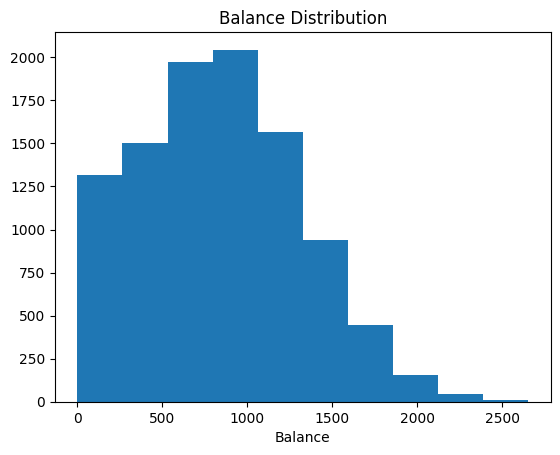

In [20]:
# # Creating and fitting the model
# selector = SelectKBest(f_classif, k=2)
# selector.fit(xUniTrain, yUniTrain)
# scores = -np.log10(selector.pvalues_)
# scores /= scores.max()

# # Now we can plot the model
# xIndices = np.arange(xUni.shape[-1])
# plt.figure(1)
# plt.clf()
# plt.bar(xIndices, scores, width=0.2)
# plt.title("Feature univariate distribution")
# plt.xlabel("Feature number")
# plt.ylabel("Score")
# plt.show()
plt.hist(xUni['balance'])
plt.title('Balance Distribution')
plt.xlabel('Balance')
plt.show()

Now lets take a look at the income.

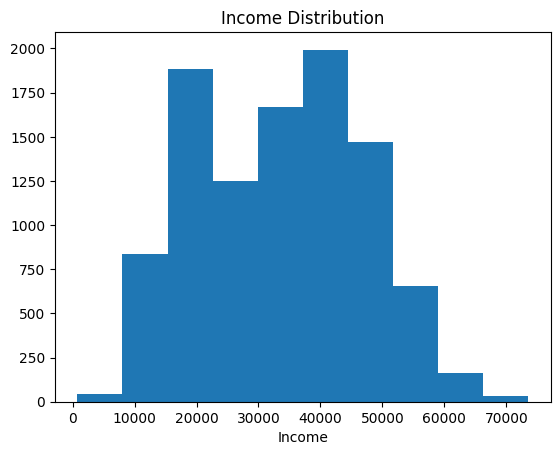

In [21]:
plt.hist(xUni['income'])
plt.title('Income Distribution')
plt.xlabel('Income')
plt.show()

Finally, we can take a look at the target.

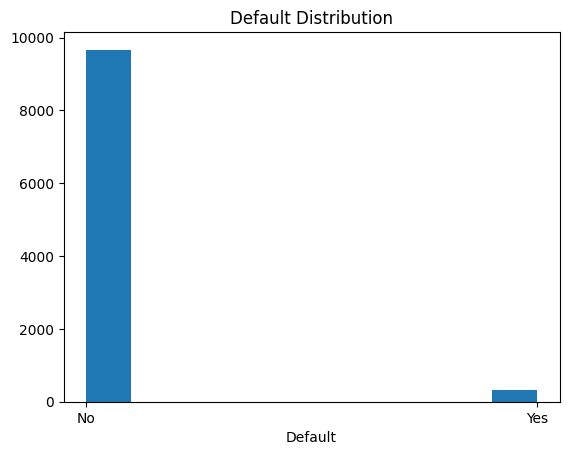

In [25]:
plt.hist(y)
plt.title('Default Distribution')
plt.xlabel('Default')
plt.show()

Based off these distributions, it looks like balance is skewed to the left a little bit, and the income seems normal. The default however is very drastic. Few people qualify for default, relative to those that don't qualify.

Now we will need to make sure the data is in the correct format to be used. Balance and income are numeric features while student is a categorical feature.

In [23]:
numFeats = ['balance', 'income']
catFeats = ['student']

numTransformer = StandardScaler()
catTransformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numTransformer, numFeats),
        ('cat', catTransformer, catFeats)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

grid = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__solver': ['lbfgs', 'liblinear']
}

Now we can start the cross-validation. For this we will do 5 folds.

In [24]:
cv = StratifiedKFold(n_splits=5)
gridSearch = GridSearchCV(pipeline, grid, cv=cv, scoring='accuracy', n_jobs=-1)

gridSearch.fit(xTrain, yTrain)

# Extracting the best parameters and score
bestParams = gridSearch.best_params_
bestScore = gridSearch.best_score_

# Evaluating the model on the test data
bestModel = gridSearch.best_estimator_
yPredTest = bestModel.predict(xTest)
yPredTrain = bestModel.predict(xTrain)

# Getting the metrics
trainAccuracy = accuracy_score(yTrain, yPredTrain)
TestAccuracy = accuracy_score(yTest, yPredTest)
trainErrorRate = 1 - trainAccuracy
testErrorRate = 1 - TestAccuracy
f1ScoreTest = f1_score(yTest, yPredTest, pos_label='Yes')

# Print metrics
print(f"Train Accuracy: {trainAccuracy*100:.2f}%")
print(f"Test Accuracy: {TestAccuracy*100:.2f}%")
print(f"Train Error Rate: {trainErrorRate*100:.2f}%")
print(f"Test Error Rate: {testErrorRate*100:.2f}%")
print(f"Test F1 Score: {f1ScoreTest:.2f}")

Train Accuracy: 97.38%
Test Accuracy: 97.25%
Train Error Rate: 2.62%
Test Error Rate: 2.75%
Test F1 Score: 0.43


# Model Comparison

# Discussion